# Generate new continua for MgII stack

In [2]:
# Load QPQ9, do a qpqsp.spec_from_coord search, if return is not None,  
# plot with continuum, prompt for generating new continuum, launch continuum fitting GUI, 
# save to a file 
# import
from specdb.specdb import SpecDB, IgmSpec
from astropy import units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord
from xastropy.xutils import fits as xxf
import linetools.utils as ltu
import numpy as np
import warnings
import linetools.spectra.xspectrum1d as lsx
import pdb,os.path
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [3]:
# Load QPQ9 
QPQ9 = xxf.bintab_to_table('/Users/lwymarie/python/enigma/enigma/data/qpq/qpq9_final.fits')
# Load QPQ database
qpq_fil = '/Users/lwymarie/Desktop/qpq_optical.hdf5'
qpqsp = SpecDB(db_file=qpq_fil,verbose=False,idkey='PRIV_ID')
igmsp = IgmSpec()

x.fits.bintab_to_table: Reading /Users/lwymarie/python/enigma/enigma/data/qpq/qpq9_final.fits


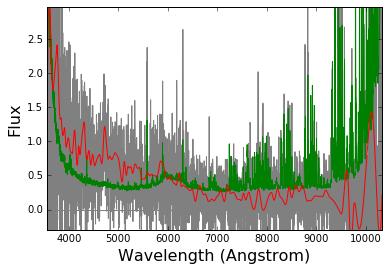

[u'00h44m39.24s -00d42m07.2s']
Fit continuum? y/n n


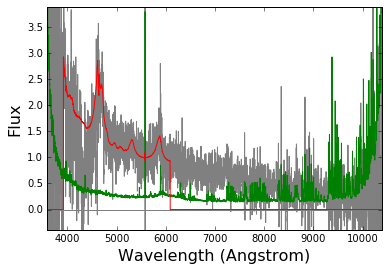

[u'00h45m55.73s +00d11m24.2s']


In [ ]:
for qq in QPQ9:
    specs,metas = qpqsp.allspec_at_coord((qq['RA']*u.deg,qq['DEC']*u.deg),verbose=False)
    if metas is not None:
        for ss,meta in enumerate(metas):
            # Check if continuum file already exists
            conti_path = '/Users/lwymarie/Dropbox/Marie_X/QPQ9/Continua/'
            ipos1 = meta['SPEC_FILE'][0].rfind('data/')+5
            ipos2 = meta['SPEC_FILE'][0].rfind('.fits')
            if ipos2 == -1: # filename not in standard format 
                pdb.set_trace()
            if 'BOSS' in meta['SPEC_FILE'][0]:
                outfil = conti_path + meta['SPEC_FILE'][0][ipos1:ipos2] + '_c.fits'
            else:
                outfil = conti_path + meta['SPEC_FILE'][0][ipos1:ipos2] + '_c.fits.gz'
            if os.path.isfile(outfil):
                continue
            # check if MgII at z_fg is covered 
#            if (meta[0]['WV_MAX'] < 2796.352*(1+ltu.z_from_v(qq['Z_FG'],3000))) or \
#            (meta[0]['WV_MIN'] > 2796.352*(1+ltu.z_from_v(qq['Z_FG'],-3000))):n
#                continue
            # Inspect continuum 
            %matplotlib inline
            specs[ss].plot()
            print(SkyCoord(meta['RA']*u.deg,meta['DEC']*u.deg).to_string('hmsdms'))
#            print('MgII lies in',np.rint(2796.352*(1+ltu.z_from_v(qq['Z_FG'],-3000))),'to',
#                  np.rint(2796.352*(1+ltu.z_from_v(qq['Z_FG'],3000))))
            fit_conti = raw_input('Fit continuum? y/n ')
            if fit_conti == 'n':
                continue
            # Fit continuum
            !rm -f _knots.jsn
            specs[ss].co = None
            %pylab
            specs[ss].fit_continuum(kind='QSO',redshift=qq['Z_FG'])# Should use z_bg, but didn't seem to result in errors
            prihdu = fits.PrimaryHDU(specs[ss].co.value)
            # Save continuum to file 
            hdu = fits.HDUList([prihdu])
            hdu.writeto(outfil,clobber=True)
            print('Saved to:',outfil)

In [ ]:
# Load igmspec database
skip_records = 625
for ii,qq in enumerate(QPQ9):
    # Skip if less than this 
    if ii < skip_records:
        continue
    # Skip J1249, not yet fluxed and ingested 
    if SkyCoord(qq['RA']*u.deg,qq['DEC']*u.deg).separation(SkyCoord('12h49m48.09s +06d07m09.2s')) < 0.5*u.arcsec:
        continue
    # Skip if in QPQ database
    specs,metas = qpqsp.allspec_at_coord((qq['RA']*u.deg,qq['DEC']*u.deg),verbose=False)
    if metas is not None:
        continue
    specs,metas = igmsp.allspec_at_coord((qq['RA']*u.deg,qq['DEC']*u.deg),verbose=False)
    print(SkyCoord(qq['RA']*u.deg,qq['DEC']*u.deg).to_string('hmsdms'))
    for ss,meta in enumerate(metas):
        # Check if continuum file already exists
        conti_path = '/Users/lwymarie/Dropbox/Marie_X/QPQ9/Continua/igmspec/'
        ipos1 = 0
        fileext = '.fits.gz'
        ipos2 = meta['SPEC_FILE'][0].rfind(fileext)
        if ipos2 == -1: 
            fileext = '.fit.gz'
            ipos2 = meta['SPEC_FILE'][0].rfind(fileext)
        if ipos2 == -1: # filename not in standard format
            pdb.set_trace()
        outfil = conti_path + meta['SPEC_FILE'][0][ipos1:ipos2] + '_c'+fileext
        if os.path.isfile(outfil):
            continue
        # Inspect continuum 
        %matplotlib inline
        specs[ss].plot()
        print('CII lies in',np.rint(1334.5323*(1+ltu.z_from_v(qq['Z_FG'],-3000))),'to',
              np.rint(1334.5323*(1+ltu.z_from_v(qq['Z_FG'],3000))),
              'MgII lies in',np.rint(2796.352*(1+ltu.z_from_v(qq['Z_FG'],-3000))),'to',
              np.rint(2796.352*(1+ltu.z_from_v(qq['Z_FG'],3000))))
        fit_conti = raw_input('Fit continuum? y/n ')
        if fit_conti == 'n':
            continue
        # Fit continuum
        !rm -f _knots.jsn
        specs[ss].co = None
        %pylab
        specs[ss].fit_continuum(kind='QSO',redshift=qq['Z_FG']) # Should use z_bg, but did't seem to result in errors
        prihdu = fits.PrimaryHDU(specs[ss].co.value)
        # Save continuum to file 
        hdu = fits.HDUList([prihdu])
        hdu.writeto(outfil,clobber=True)
        print('Saved to:',outfil)

# Generate continua for foreground quasars 

195
[u'15h17m44.7936s +20d03m04.3596s']


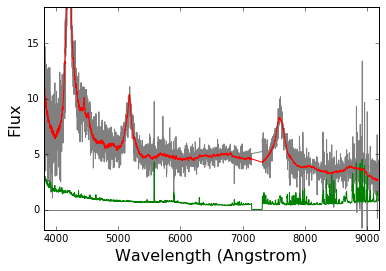

('CII lies in', 3591.0, 'to', 3663.0, 'CIV lies in', 4165.0, 'to', 4250.0, 'MgII lies in', 7524.0, 'to', 7676.0)
Fit continuum? y/n n
[u'15h30m27.3293s +25d15m08.3556s']


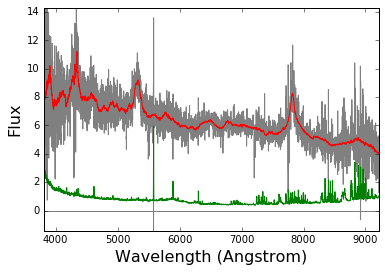

('CII lies in', 3691.0, 'to', 3766.0, 'CIV lies in', 4282.0, 'to', 4369.0, 'MgII lies in', 7735.0, 'to', 7891.0)
Fit continuum? y/n n
[u'15h34m56.0201s +21d53m42.3204s']


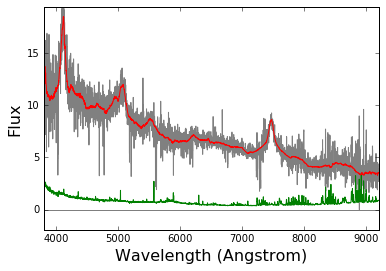

('CII lies in', 3526.0, 'to', 3598.0, 'CIV lies in', 4091.0, 'to', 4174.0, 'MgII lies in', 7389.0, 'to', 7538.0)
Fit continuum? y/n n
[u'15h38m51.977s +57d08m14.514s']


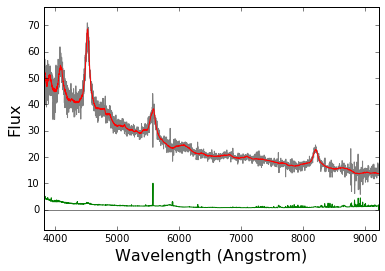

('CII lies in', 3872.0, 'to', 3951.0, 'CIV lies in', 4492.0, 'to', 4583.0, 'MgII lies in', 8114.0, 'to', 8278.0)
Fit continuum? y/n n
[u'15h39m54.744s +31d46m29.2836s']
[u'15h54m22.8773s +12d44m38.0076s']


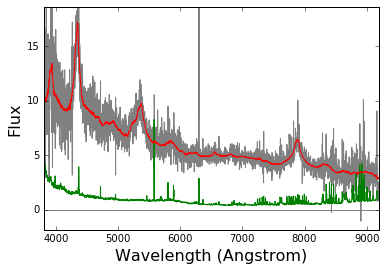

('CII lies in', 3721.0, 'to', 3796.0, 'CIV lies in', 4316.0, 'to', 4404.0, 'MgII lies in', 7796.0, 'to', 7954.0)
Fit continuum? y/n n
[u'15h56m20.754s +30d41m21.9372s']


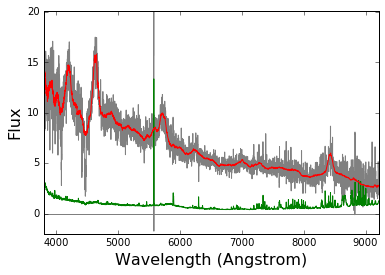

('CII lies in', 3978.0, 'to', 4058.0, 'CIV lies in', 4614.0, 'to', 4708.0, 'MgII lies in', 8334.0, 'to', 8503.0)
Fit continuum? y/n n
[u'15h57m43.0658s +04d34m39.2016s']


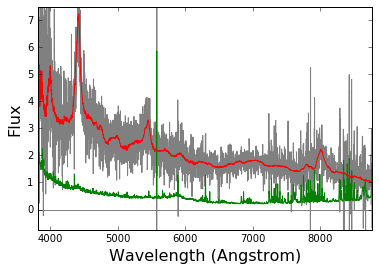

('CII lies in', 3780.0, 'to', 3856.0, 'CIV lies in', 4385.0, 'to', 4473.0, 'MgII lies in', 7920.0, 'to', 8080.0)
Fit continuum? y/n n
[u'16h18m16.4453s +18d42m08.208s']


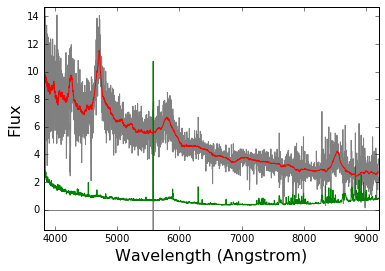

('CII lies in', 4027.0, 'to', 4109.0, 'CIV lies in', 4672.0, 'to', 4766.0, 'MgII lies in', 8439.0, 'to', 8609.0)
Fit continuum? y/n n
[u'16h19m30.937s +19d26m20.8968s']


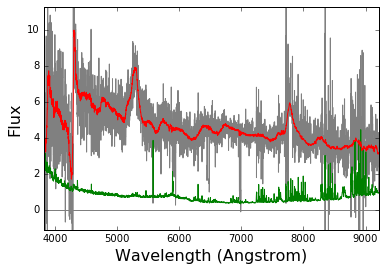

('CII lies in', 3675.0, 'to', 3749.0, 'CIV lies in', 4263.0, 'to', 4349.0, 'MgII lies in', 7700.0, 'to', 7856.0)
Fit continuum? y/n y
Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib

i,o          Zoom in/out x limits
y            Zoom out y limits
Y            Guess y limits
t,b          Set y top/bottom limit
l,r          Set left/right x limit
[,]          Pan left/right
w            Plot the whole spectrum

S,U          Smooth/unsmooth spectrum

a        : add a new spline knot
A        : add a new spline knot, and use a flux median to guess y position
+        : double the number of spline knots
_        : halve the number of spline knots
d        : delete the nearest knot
m        : move the nearest knot
M        : move the nearest knot, and use a flux median to guess y position

q        : quit

Updating continuum.
('Saved to:', '/Users/lwymarie/Dropbox/Marie_X/QPQ9/Continua/igmspec/spSpec-53795-2206-024_c.fit.gz')
[u'16h28m24.5196s

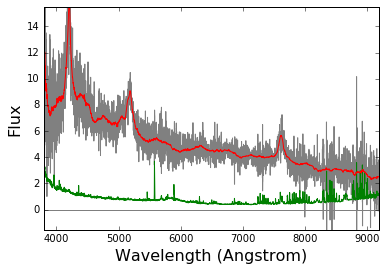

('CII lies in', 3594.0, 'to', 3667.0, 'CIV lies in', 4170.0, 'to', 4254.0, 'MgII lies in', 7531.0, 'to', 7684.0)
Fit continuum? y/n n
[u'16h31m21.7442s +43d33m17.298s']


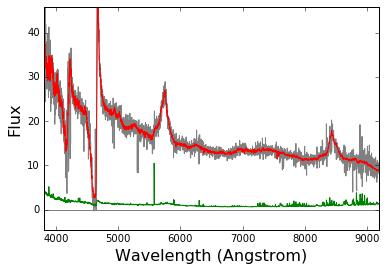

('CII lies in', 3986.0, 'to', 4066.0, 'CIV lies in', 4624.0, 'to', 4717.0, 'MgII lies in', 8351.0, 'to', 8520.0)
Fit continuum? y/n y
Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib

i,o          Zoom in/out x limits
y            Zoom out y limits
Y            Guess y limits
t,b          Set y top/bottom limit
l,r          Set left/right x limit
[,]          Pan left/right
w            Plot the whole spectrum

S,U          Smooth/unsmooth spectrum

a        : add a new spline knot
A        : add a new spline knot, and use a flux median to guess y position
+        : double the number of spline knots
_        : halve the number of spline knots
d        : delete the nearest knot
m        : move the nearest knot
M        : move the nearest knot, and use a flux median to guess y position

q        : quit

Updating continuum.
('Saved to:', '/Users/lwymarie/Dropbox/Marie_X/QPQ9/Continua/igmspec/spSpec-52057-0626-237_c.fit.gz')
[u'16h31m30.2076s

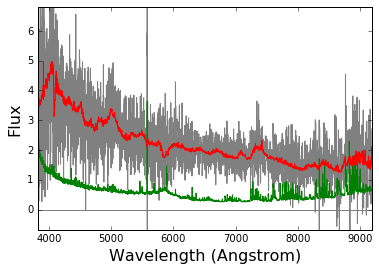

('CII lies in', 3488.0, 'to', 3558.0, 'CIV lies in', 4046.0, 'to', 4128.0, 'MgII lies in', 7308.0, 'to', 7455.0)
Fit continuum? y/n y
Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib

i,o          Zoom in/out x limits
y            Zoom out y limits
Y            Guess y limits
t,b          Set y top/bottom limit
l,r          Set left/right x limit
[,]          Pan left/right
w            Plot the whole spectrum

S,U          Smooth/unsmooth spectrum

a        : add a new spline knot
A        : add a new spline knot, and use a flux median to guess y position
+        : double the number of spline knots
_        : halve the number of spline knots
d        : delete the nearest knot
m        : move the nearest knot
M        : move the nearest knot, and use a flux median to guess y position

q        : quit

Updating continuum.
('Saved to:', '/Users/lwymarie/Dropbox/Marie_X/QPQ9/Continua/igmspec/spSpec-52765-1338-604_c.fit.gz')
[u'16h35m46.2979s

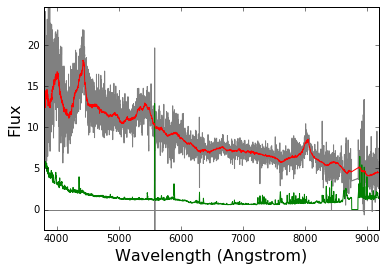

('CII lies in', 3791.0, 'to', 3867.0, 'CIV lies in', 4398.0, 'to', 4487.0, 'MgII lies in', 7943.0, 'to', 8104.0)
Fit continuum? y/n n
[u'16h51m59.0059s +34d10m48.648s']


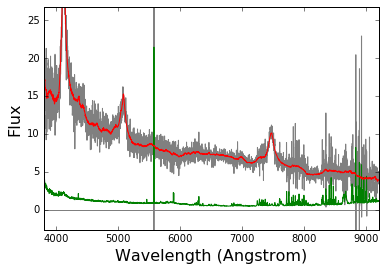

('CII lies in', 3526.0, 'to', 3597.0, 'CIV lies in', 4091.0, 'to', 4173.0, 'MgII lies in', 7389.0, 'to', 7538.0)
Fit continuum? y/n n
[u'20h53m03.4759s -01d04m15.0852s']


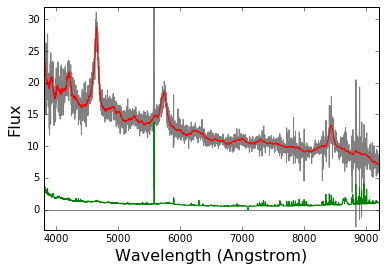

('CII lies in', 3981.0, 'to', 4062.0, 'CIV lies in', 4619.0, 'to', 4712.0, 'MgII lies in', 8342.0, 'to', 8511.0)
Fit continuum? y/n n
[u'21h56m55.1374s -00d04m00.9732s']


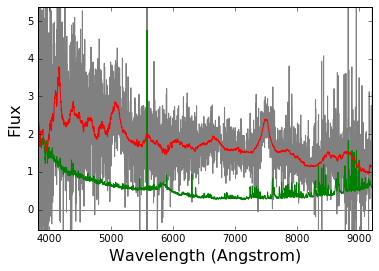

('CII lies in', 3539.0, 'to', 3611.0, 'CIV lies in', 4106.0, 'to', 4189.0, 'MgII lies in', 7416.0, 'to', 7566.0)
Fit continuum? y/n n
[u'22h12m27.4366s -00d11m58.4412s']


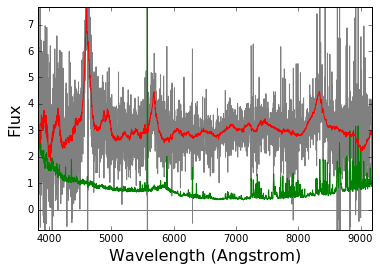

('CII lies in', 3939.0, 'to', 4019.0, 'CIV lies in', 4570.0, 'to', 4662.0, 'MgII lies in', 8254.0, 'to', 8421.0)
Fit continuum? y/n n
[u'22h55m35.6662s -00d01m56.8416s']


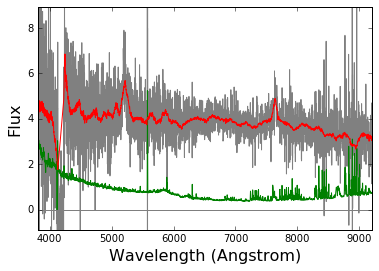

('CII lies in', 3610.0, 'to', 3683.0, 'CIV lies in', 4188.0, 'to', 4272.0, 'MgII lies in', 7564.0, 'to', 7717.0)
Fit continuum? y/n y
Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib

i,o          Zoom in/out x limits
y            Zoom out y limits
Y            Guess y limits
t,b          Set y top/bottom limit
l,r          Set left/right x limit
[,]          Pan left/right
w            Plot the whole spectrum

S,U          Smooth/unsmooth spectrum

a        : add a new spline knot
A        : add a new spline knot, and use a flux median to guess y position
+        : double the number of spline knots
_        : halve the number of spline knots
d        : delete the nearest knot
m        : move the nearest knot
M        : move the nearest knot, and use a flux median to guess y position

q        : quit

Updating continuum.
('Saved to:', '/Users/lwymarie/Dropbox/Marie_X/QPQ9/Continua/igmspec/spSpec-52178-0676-077_c.fit.gz')
[u'22h55m50.4007s

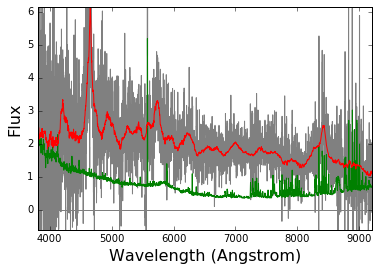

('CII lies in', 3977.0, 'to', 4057.0, 'CIV lies in', 4614.0, 'to', 4707.0, 'MgII lies in', 8333.0, 'to', 8502.0)
Fit continuum? y/n n
[u'23h14m25.1326s -01d09m02.9268s']


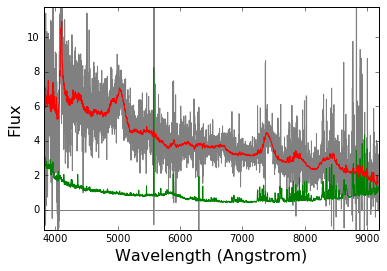

('CII lies in', 3497.0, 'to', 3567.0, 'CIV lies in', 4056.0, 'to', 4138.0, 'MgII lies in', 7327.0, 'to', 7475.0)
Fit continuum? y/n y
Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib

i,o          Zoom in/out x limits
y            Zoom out y limits
Y            Guess y limits
t,b          Set y top/bottom limit
l,r          Set left/right x limit
[,]          Pan left/right
w            Plot the whole spectrum

S,U          Smooth/unsmooth spectrum

a        : add a new spline knot
A        : add a new spline knot, and use a flux median to guess y position
+        : double the number of spline knots
_        : halve the number of spline knots
d        : delete the nearest knot
m        : move the nearest knot
M        : move the nearest knot, and use a flux median to guess y position

q        : quit

Updating continuum.
('Saved to:', '/Users/lwymarie/Dropbox/Marie_X/QPQ9/Continua/igmspec/spSpec-51816-0382-291_c.fit.gz')
[u'23h41m09.3132s

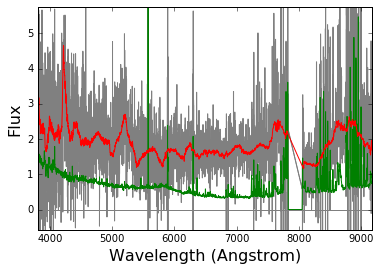

('CII lies in', 3609.0, 'to', 3682.0, 'CIV lies in', 4186.0, 'to', 4271.0, 'MgII lies in', 7561.0, 'to', 7714.0)
Fit continuum? y/n n
[u'23h48m30.984s +01d10m37.6608s']


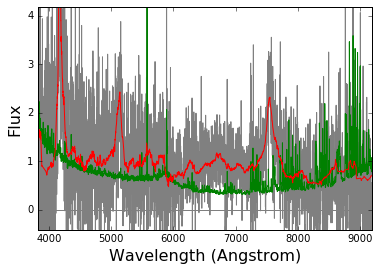

('CII lies in', 3560.0, 'to', 3632.0, 'CIV lies in', 4130.0, 'to', 4214.0, 'MgII lies in', 7460.0, 'to', 7611.0)
Fit continuum? y/n n
[u'23h52m32.0748s -00d15m03.9456s']


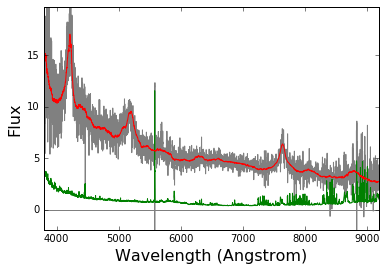

('CII lies in', 3604.0, 'to', 3677.0, 'CIV lies in', 4181.0, 'to', 4265.0, 'MgII lies in', 7551.0, 'to', 7704.0)
Fit continuum? y/n n
[u'23h54m21.3528s -00d19m12.1476s']


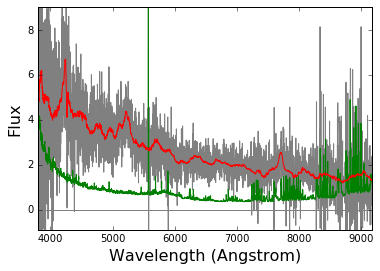

('CII lies in', 3639.0, 'to', 3712.0, 'CIV lies in', 4221.0, 'to', 4306.0, 'MgII lies in', 7624.0, 'to', 7778.0)
Fit continuum? y/n y
Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib

i,o          Zoom in/out x limits
y            Zoom out y limits
Y            Guess y limits
t,b          Set y top/bottom limit
l,r          Set left/right x limit
[,]          Pan left/right
w            Plot the whole spectrum

S,U          Smooth/unsmooth spectrum

a        : add a new spline knot
A        : add a new spline knot, and use a flux median to guess y position
+        : double the number of spline knots
_        : halve the number of spline knots
d        : delete the nearest knot
m        : move the nearest knot
M        : move the nearest knot, and use a flux median to guess y position

q        : quit

Updating continuum.
('Saved to:', '/Users/lwymarie/Dropbox/Marie_X/QPQ9/Continua/igmspec/spSpec-52523-0684-157_c.fit.gz')


In [25]:
# Only for z > 1.6
high_z = np.where(QPQ9['Z_FG'] > 1.6)[0]
print(len(high_z))
skip_records = 160
for ii,qq in enumerate(QPQ9[high_z]):
    # Skip if less than this 
    if ii < skip_records:
        continue
    specs,metas = qpqsp.allspec_at_coord((qq['FG_RA']*u.deg,qq['FG_DEC']*u.deg),verbose=False)
    if metas is None:
        specs,metas = igmsp.allspec_at_coord((qq['FG_RA']*u.deg,qq['FG_DEC']*u.deg),verbose=False)
        if metas is None:
            continue
        for ss,meta in enumerate(metas):
            print(SkyCoord(meta['RA_GROUP']*u.deg,meta['DEC_GROUP']*u.deg).to_string('hmsdms'))
            conti_path = '/Users/lwymarie/Dropbox/Marie_X/QPQ9/Continua/igmspec/'
            ipos1 = 0
            fileext = '.fit.gz'
            ipos2 = meta['SPEC_FILE'][0].rfind(fileext)
            if ipos2 == -1:
                fileext = '.fits.gz'
                ipos2 = meta['SPEC_FILE'][0].rfind(fileext)
            if ipos2 == -1:
                pdb.set_trace()
            outfil = conti_path + meta['SPEC_FILE'][0][ipos1:ipos2]+'_c'+fileext
            if os.path.isfile(outfil):
                continue
            covered = 0
            if ((meta[0]['WV_MAX'] > 2796.352*(1+ltu.z_from_v(qq['Z_FG'],3000))) & 
                (meta[0]['WV_MIN'] < 2796.352*(1+ltu.z_from_v(qq['Z_FG'],-3000)))):
                covered = 1
            if ((meta[0]['WV_MAX'] > 1548.195*(1+ltu.z_from_v(qq['Z_FG'],3000))) & 
                (meta[0]['WV_MIN'] < 1548.195*(1+ltu.z_from_v(qq['Z_FG'],-3000)))):
                covered = 1
            if ((meta[0]['WV_MAX'] > 1334.5323*(1+ltu.z_from_v(qq['Z_FG'],3000))) & 
                (meta[0]['WV_MIN'] < 1334.5323*(1+ltu.z_from_v(qq['Z_FG'],-3000)))):
                covered = 1
            if covered == 0:
                continue
            %matplotlib inline
            specs[ss].plot()
            print('CII lies in',np.rint(1334.5323*(1+ltu.z_from_v(qq['Z_FG'],-3000))),'to',
                  np.rint(1334.5323*(1+ltu.z_from_v(qq['Z_FG'],3000))),
                  'CIV lies in',np.rint(1548.195*(1+ltu.z_from_v(qq['Z_FG'],-3000))),'to',
                  np.rint(1548.195*(1+ltu.z_from_v(qq['Z_FG'],3000))),
                  'MgII lies in',np.rint(2796.352*(1+ltu.z_from_v(qq['Z_FG'],-3000))),'to',
                  np.rint(2796.352*(1+ltu.z_from_v(qq['Z_FG'],3000))))
            fit_conti = raw_input('Fit continuum? y/n ')
            if fit_conti == 'n':
                continue
            !rm -f _knots.jsn
            specs[ss].co = None
            %pylab
            specs[ss].fit_continuum(kind='QSO',redshift=qq['Z_FG'])
            prihdu = fits.PrimaryHDU(specs[ss].co.value) 
            hdu = fits.HDUList([prihdu])
            hdu.writeto(outfil,clobber=True)
            print('Saved to:',outfil)
    else:
        continue # skip doing QPQ continua, done alraedy
        for ss,meta in enumerate(metas):
            print(SkyCoord(meta['RA']*u.deg,meta['DEC']*u.deg).to_string('hmsdms'))
            # Check if continuum file already exists
            conti_path = '/Users/lwymarie/Dropbox/Marie_X/QPQ9/Continua/QPQ/'
            ipos1 = meta['SPEC_FILE'][0].rfind('data/')+5
            fileext = '.fits.gz'
            ipos2 = meta['SPEC_FILE'][0].rfind(fileext)
            if ipos2 == -1: 
                fileext = '.fit.gz'
                ipos2 = meta['SPEC_FILE'][0].rfind(fileext)
            if ipos2 == -1:
                fileext = '.fits'
                ipos2 = meta['SPEC_FILE'][0].rfind(fileext)
            if ipos2 == -1: # filename not in standard format
                pdb.set_trace()
            outfil = conti_path + meta['SPEC_FILE'][0][ipos1:ipos2] + '_c'+fileext
            if os.path.isfile(outfil):
                continue
            # check if CII, CIV, MgII at z_fg is covered 
            covered = 0
            if ((meta[0]['WV_MAX'] > 2796.352*(1+ltu.z_from_v(qq['Z_FG'],3000))) & 
                (meta[0]['WV_MIN'] < 2796.352*(1+ltu.z_from_v(qq['Z_FG'],-3000)))):
                covered = 1
            if ((meta[0]['WV_MAX'] > 1548.195*(1+ltu.z_from_v(qq['Z_FG'],3000))) & 
                (meta[0]['WV_MIN'] < 1548.195*(1+ltu.z_from_v(qq['Z_FG'],-3000)))):
                covered = 1
            if ((meta[0]['WV_MAX'] > 1334.5323*(1+ltu.z_from_v(qq['Z_FG'],3000))) & 
                (meta[0]['WV_MIN'] < 1334.5323*(1+ltu.z_from_v(qq['Z_FG'],-3000)))):
                covered = 1
            if covered == 0:
                continue
            # Inspect continuum 
            %matplotlib inline
            specs[ss].plot()
            print('CII lies in',np.rint(1334.5323*(1+ltu.z_from_v(qq['Z_FG'],-3000))),'to',
                  np.rint(1334.5323*(1+ltu.z_from_v(qq['Z_FG'],3000))),
                  'CIV lies in',np.rint(1548.195*(1+ltu.z_from_v(qq['Z_FG'],-3000))),'to',
                  np.rint(1548.195*(1+ltu.z_from_v(qq['Z_FG'],3000))),
                  'MgII lies in',np.rint(2796.352*(1+ltu.z_from_v(qq['Z_FG'],-3000))),'to',
                  np.rint(2796.352*(1+ltu.z_from_v(qq['Z_FG'],3000))))
            fit_conti = raw_input('Fit continuum? y/n ')
            if fit_conti == 'n':
                continue
            # Fit continuum
            !rm -f _knots.jsn
            specs[ss].co = None
            %pylab
            specs[ss].fit_continuum(kind='QSO',redshift=qq['Z_FG'])
            prihdu = fits.PrimaryHDU(specs[ss].co.value)
            # Save continuum to file 
            hdu = fits.HDUList([prihdu])
            hdu.writeto(outfil,clobber=True)
            print('Saved to:',outfil)

In [7]:
count_igmsp

136